# Model for classifying bank transactions as regular or fraudulent

The data used was provided by [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud#) and consists of credit card transactions in September 2013 in Europe. The transactions took place in two days.

I thank Rafael Bastos for the excellent [article](https://github.com/rmpbastos/data_science/blob/master/Credit_Card_Fraud_Detection.ipynb)

## Importing libraries 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from scipy.stats import reciprocal, uniform

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler

## Import dataset

In [2]:
df_fraud = pd.read_csv('creditcard.csv')

## Exploratory Analysis

In [3]:
df_fraud.describe

<bound method NDFrame.describe of             Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62      0
1            0.0   1.191857   0.266151  ...  0.014724    2.69      0
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66      0
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50      0
4            2.0  -1.158233   0.877737  ...  0.215153   69.99      0
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77      0
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79      0
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88      0
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00      0
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00      0

[284807 rows x 31 columns]>

In [4]:
df_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Columns V1 to V28 have undergone the PCA transformation in order to preserve data anonymity

In [5]:
df_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df_fraud.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Detecting Correlations

In [8]:
corrMatrix = df_fraud.corr()
corrMatrix['Class'].sort_values(ascending = False)

Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64

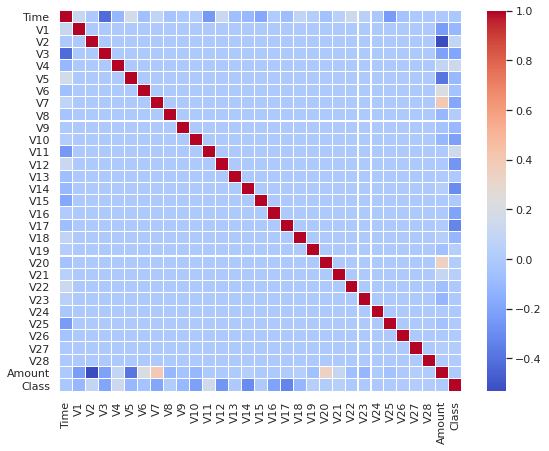

In [9]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(df_fraud[df_fraud.columns].corr(), fmt='.2f', cmap='coolwarm', ax=ax, linewidths=.1)

No strong relationship is observed

In [10]:
print(df_fraud['Class'].value_counts())
print('\nPercentage of fraudulent activity: {:.2%}'.format((df_fraud[df_fraud['Class'] == 1].shape[0] / df_fraud.shape[0])))

0    284315
1       492
Name: Class, dtype: int64

Percentage of fraudulent activity: 0.17%


There is more information about regular transactions than fraudulent

### Distribution of the different types of transactions over time

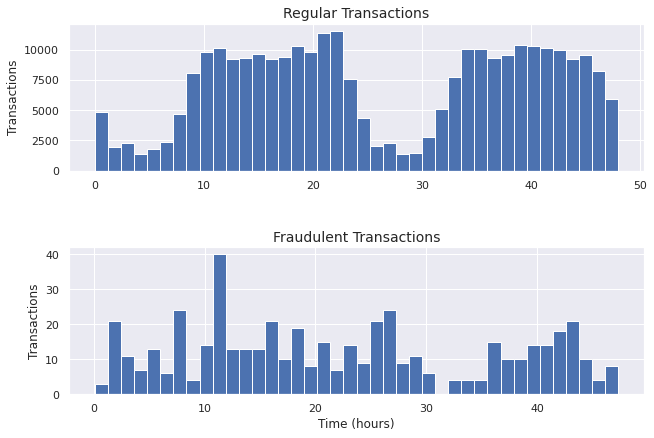

In [11]:
hoursRT = df_fraud['Time'][df_fraud['Class'] == 0] / 3600
hoursFT = df_fraud['Time'][df_fraud['Class'] == 1] / 3600

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

ax[0].hist(hoursRT, bins=40)
ax[0].set_title('Regular Transactions', fontsize=14)
ax[0].set_ylabel('Transactions')

ax[1].hist(hoursFT, bins=40)
ax[1].set_title('Fraudulent Transactions', fontsize=14)
ax[1].set_ylabel('Transactions')
ax[1].set_xlabel('Time (hours)')

plt.tight_layout(pad=4.0)

### Distribution of the different types of transactions and their amounts

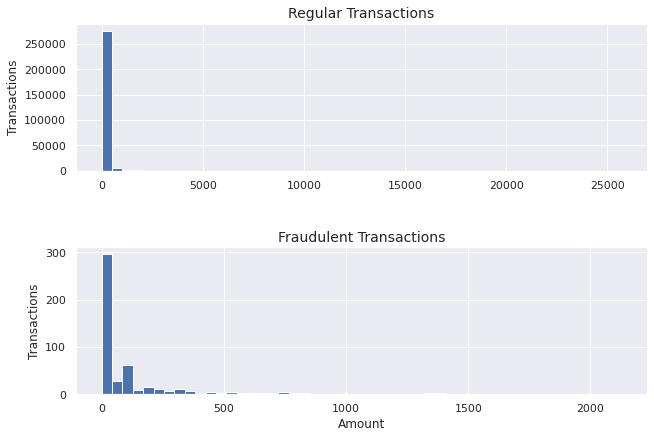

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

ax[0].hist(df_fraud['Amount'][df_fraud['Class'] == 0], bins=50)
ax[0].set_title('Regular Transactions', fontsize=14)
ax[0].set_ylabel('Transactions')

ax[1].hist(df_fraud['Amount'][df_fraud['Class'] == 1], bins=50)
ax[1].set_title('Fraudulent Transactions', fontsize=14)
ax[1].set_ylabel('Transactions')
ax[1].set_xlabel('Amount')

plt.tight_layout(pad=4.0)

## Dataset split into training set and test set

In [13]:
X = df_fraud.drop('Class', axis=1)
y = df_fraud['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Data pre-processing

### Scaling of time and amount variables

In [14]:
ss = StandardScaler()

X_train['std_amount'] = ss.fit_transform(X_train['Amount'].values.reshape(-1, 1))
X_train['std_time'] = ss.fit_transform(X_train['Time'].values.reshape(-1, 1))
X_test['std_amount'] = ss.transform(X_test['Amount'].values.reshape(-1, 1))
X_test['std_time'] = ss.transform(X_test['Time'].values.reshape(-1, 1))

X_train.drop(['Amount', 'Time'], axis=1, inplace=True)
X_test.drop(['Amount', 'Time'], axis=1, inplace=True)

X_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,std_amount,std_time
68806,-1.115047,1.035583,0.800712,-1.060398,0.032621,0.853422,-0.614243,-3.231161,1.539948,-0.816909,-1.305592,0.108177,-0.859610,-0.071934,0.906656,-1.720930,0.797853,-0.006759,1.956778,-0.644896,3.020385,-0.539618,0.033156,-0.774946,0.105868,-0.430853,0.229737,-0.070591,-0.305116,-0.877510
40018,1.228473,-0.138826,0.473795,-0.166381,-0.453564,-0.190135,-0.355309,0.048598,0.128943,-0.014495,0.900158,0.833158,0.469162,0.187845,0.598188,0.923461,-0.934009,0.262930,0.500875,0.032481,-0.172147,-0.574730,0.036834,-0.303782,0.073315,0.810356,-0.069178,0.001890,-0.254237,-1.153085
250360,1.926148,-0.198628,-0.286727,1.596852,-0.488963,-0.311405,-0.303207,0.035513,1.301312,0.007083,-1.395983,0.317771,-1.035108,-0.098650,-1.079728,-0.447185,0.055404,-0.873889,0.145642,-0.355216,-0.528432,-1.251300,0.455607,-0.120530,-0.361515,-1.099295,0.052747,-0.032622,-0.329508,1.263832
234820,2.046232,0.196183,-1.704650,0.530027,0.177496,-1.443091,0.255403,-0.365759,0.602945,-0.478188,-0.313962,0.036516,-0.096162,-0.705034,0.955017,0.148201,0.458095,0.421809,-0.504199,-0.216247,0.201104,0.757245,-0.013600,-0.079318,0.234805,-0.098151,0.000028,-0.031675,-0.338982,1.122044
10001,-0.837077,1.034710,2.333129,3.103776,0.229143,0.501123,0.314283,-0.161583,0.409634,0.889521,1.748413,-2.533696,0.780430,1.352159,-1.190343,-0.361568,0.775921,0.504177,1.371433,-0.134542,-0.363839,-0.458101,0.164097,0.234167,-0.418734,-0.074078,-0.355165,-0.169616,-0.342046,-1.680363


In [15]:
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,std_amount,std_time
183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,-1.118863,0.202647,1.145965,-1.802360,-0.247178,-0.060945,0.846606,0.379454,0.847262,0.186409,-0.207098,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,-1.995601,0.652387
255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,-0.854776,-0.620458,-0.806471,-0.770837,-0.108158,0.258964,0.492095,-0.148516,-0.148099,-0.096502,-0.271537,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,-1.996401,1.313726
244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,-1.726259,-0.736771,-1.516835,0.348343,0.041437,0.732681,-1.136766,0.816653,-1.578951,0.419835,0.701399,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,-1.994422,1.213432
63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,1.551682,0.435125,-0.336022,0.278965,1.812232,0.080001,0.116347,0.291818,0.106228,-0.987790,0.810408,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,-1.989959,-0.924309
11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,0.664531,-3.282511,0.409266,1.252202,-0.868774,0.214387,1.878003,-1.906559,0.263854,-0.126871,-0.139436,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,-1.996338,-1.577522


### Rebalancing the training data set

In [16]:
rus = RandomUnderSampler()
X_train, y_train = rus.fit_sample(X_train, y_train)
print(Counter(y_train))

Counter({0: 391, 1: 391})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Training

### Logistic Regression

In [17]:
log_classifier = LogisticRegression(random_state=0)
log_classifier.fit(X_train, y_train)
y_pred_log = log_classifier.predict(X_test)

### Random Forest Classification

In [18]:
param_grid = [
  {'n_estimators': [3, 10, 30, 60], 'max_features': [7, 14, 22, 30]},
  {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [7, 14, 22, 30]},
]

forest_cla = RandomForestClassifier()
grid_search = GridSearchCV(forest_cla, param_grid, cv=5)
grid_search.fit(X_train, y_train)

forest_classifier = grid_search.best_estimator_

grid_search.best_params_

{'max_features': 7, 'n_estimators': 60}

### Support Vector Machine

In [19]:
svm = SVC(gamma="auto", random_state=0, probability=True)
svm.fit(X_train, y_train)

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train, y_train)

svm_classifier = rnd_search_cv.best_estimator_
rnd_search_cv.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=2.731154694429126, gamma=0.010052401885724194 .................
[CV] .. C=2.731154694429126, gamma=0.010052401885724194, total=   0.0s
[CV] C=2.731154694429126, gamma=0.010052401885724194 .................
[CV] .. C=2.731154694429126, gamma=0.010052401885724194, total=   0.0s
[CV] C=2.731154694429126, gamma=0.010052401885724194 .................
[CV] .. C=2.731154694429126, gamma=0.010052401885724194, total=   0.0s
[CV] C=7.580074034646561, gamma=0.00948559242519608 ..................
[CV] ... C=7.580074034646561, gamma=0.00948559242519608, total=   0.0s
[CV] C=7.580074034646561, gamma=0.00948559242519608 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ... C=7.580074034646561, gamma=0.00948559242519608, total=   0.1s
[CV] C=7.580074034646561, gamma=0.00948559242519608 ..................
[CV] ... C=7.580074034646561, gamma=0.00948559242519608, total=   0.1s
[CV] C=5.158624950500371, gamma=0.03629197264288915 ..................
[CV] ... C=5.158624950500371, gamma=0.03629197264288915, total=   0.1s
[CV] C=5.158624950500371, gamma=0.03629197264288915 ..................
[CV] ... C=5.158624950500371, gamma=0.03629197264288915, total=   0.1s
[CV] C=5.158624950500371, gamma=0.03629197264288915 ..................
[CV] ... C=5.158624950500371, gamma=0.03629197264288915, total=   0.1s
[CV] C=9.158817963312773, gamma=0.02354201051658872 ..................
[CV] ... C=9.158817963312773, gamma=0.02354201051658872, total=   0.1s
[CV] C=9.158817963312773, gamma=0.02354201051658872 ..................
[CV] ... C=9.158817963312773, gamma=0.02354201051658872, total=   0.1s
[CV] C=9.158817963312773, gamma=0.02354201051658872 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.0s finished


{'C': 7.580074034646561, 'gamma': 0.00948559242519608}

### Ensemble

In [20]:
vt_classifier = VotingClassifier(
    estimators=[('lr', log_classifier), ('rf', forest_classifier), ('svc', svm_classifier)],
    voting='soft')

vt_classifier.fit(X_train, y_train)
y_pred = vt_classifier.predict(X_test)

## Performance indicator 

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56861
           1       0.09      0.91      0.16       101

    accuracy                           0.98     56962
   macro avg       0.55      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962



In [22]:
confusion_matrix(y_test, y_pred, normalize='true')

array([[0.98374985, 0.01625015],
       [0.08910891, 0.91089109]])

The model showed high accuracy, managing to predict the true positives and true negatives well.